# Case - 成型機PHM,  案例分類 - DTW

Copyright © 2019 Hsu Shih-Chieh 

分析每一個兩個案例的之間的參數變化相似性

算法筆記: https://hackmd.io/@JHSU/HyCnabcPH


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings, matplotlib, datetime
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datasets import load_moldcase
from utils import set_font_cn
from IPython.display import display
from tqdm.notebook import tqdm
from collections import Counter
import dtaidistance.dtw_visualisation
from dtw import dtw
from sklearn.preprocessing import MinMaxScaler

set_font_cn()

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Segmentation Models: using `keras` framework.


/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load Data

In [2]:
data= load_moldcase()
print(data.DESCR)

成型機案例數據
---------------------------

**Data Set Characteristics::**

    :控制器數據: 從控制器取出的螺桿位置, 油壓缸壓力, 料管溫度的數據統計值, 總共有44種數據
    
    :設備健康值數據: 透過高維度SPC監控方法(PCA T2/SPE)計算後的設備健康值, 設備運作時實時運算, 並存入sqlite
    
    :spccol_mapping: PLC數據欄位的中英文對照表
    
    :caseinfo: 每一個案例的詳細資訊



**讀取數據Sample Code**

::
    data= load_moldcase()
    c = data.case01_caseinfo
    df_ctr = data.case01_plc
    df_hv = data.case01_hv


**Model Characteristics**
    
    :設備異常監控: PCA T2/SPE
    
    :設備異常分類(方法一): 案例的參數趨勢分析
        - Source Code: data_molding_TrendAnalysis.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/By3uWuwPH
    
    :設備異常分類(方法一): 分析每一個兩個案例的之間的參數變化相似性
        - Source Code: data_molding_DTW.ipynb
        - 算法筆記: https://hackmd.io/@JHSU/HyCnabcPH


專案說明：
這個專案與控制器廠商合作, 從控制器中取出螺桿位置, 油壓缸壓力, 料管溫度這三項特徵數據, 但因為控制器性能限制, 無法將實時數據取出, 退而求其次, 透過控制器本身的SPC監控功能, 取出這三項特徵的44種統計數據(ex: 最大值, 最小值,...), 並透過這些數據進行設備異常監控與設備異常分類





### Pre-process
- 準備DTW分析要用的數據, 
    - Case1/Case2的控制器數據 - df_ctr1/df_ctr2
    - Case1/Case2在Event區間的控制器數據 - df_evt1/df_ctr2
    - Case1/Case2的Event區間數據的Normalize - df_sca1/df_ctr2

In [3]:
spc_feature=['SPC_7','SPC_6','SPC_40','SPC_9','SPC_19','SPC_20','SPC_24','SPC_28','SPC_32','SPC_33']
c1, c2=data.case01_caseinfo, data.case02_caseinfo
print(c1.cname,', ', c2.cname)
scaler = MinMaxScaler()
df_ctr1 = data.case01_plc
df_ctr1['dt'] = df_ctr1['dt'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df_evt1 = df_ctr1.loc[c1.evt_str:c1.evt_end]      
df_sca1 = scaler.fit_transform(df_evt1[spc_feature])

df_ctr2 = data.case02_plc
df_ctr2['dt'] = df_ctr2['dt'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
df_evt2 = df_ctr2.loc[c2.evt_str:c2.evt_end]      
df_sca2 = scaler.fit_transform(df_evt2[spc_feature])


D2 A05 9/10 清模 ,  D2 A05 9/11 清模


### DTW分析
以下為分析步驟
1. 直接使用dtw套件得到dtw分析結果
    - 分析結果 - dict_dtwSummary

In [4]:
dict_dtwSummary={}
euclidean_norm = lambda x, y: np.abs(x - y)
for i,f in enumerate(spc_feature):
    d, cost_matrix, acc_cost_matrix, path = dtw(df_sca1[:,i], df_sca2[:,i] ,dist=euclidean_norm)
    dict_dtwSummary[f]={'d':d, 'path':path,}            



### 畫圖
- 畫出每個參數的Case參數趨勢圖, 並標註
    - 第一欄：Case 1參數趨勢圖
    - 第二欄：Case 2參數趨勢圖
    - 第三欄：DTW分析結果

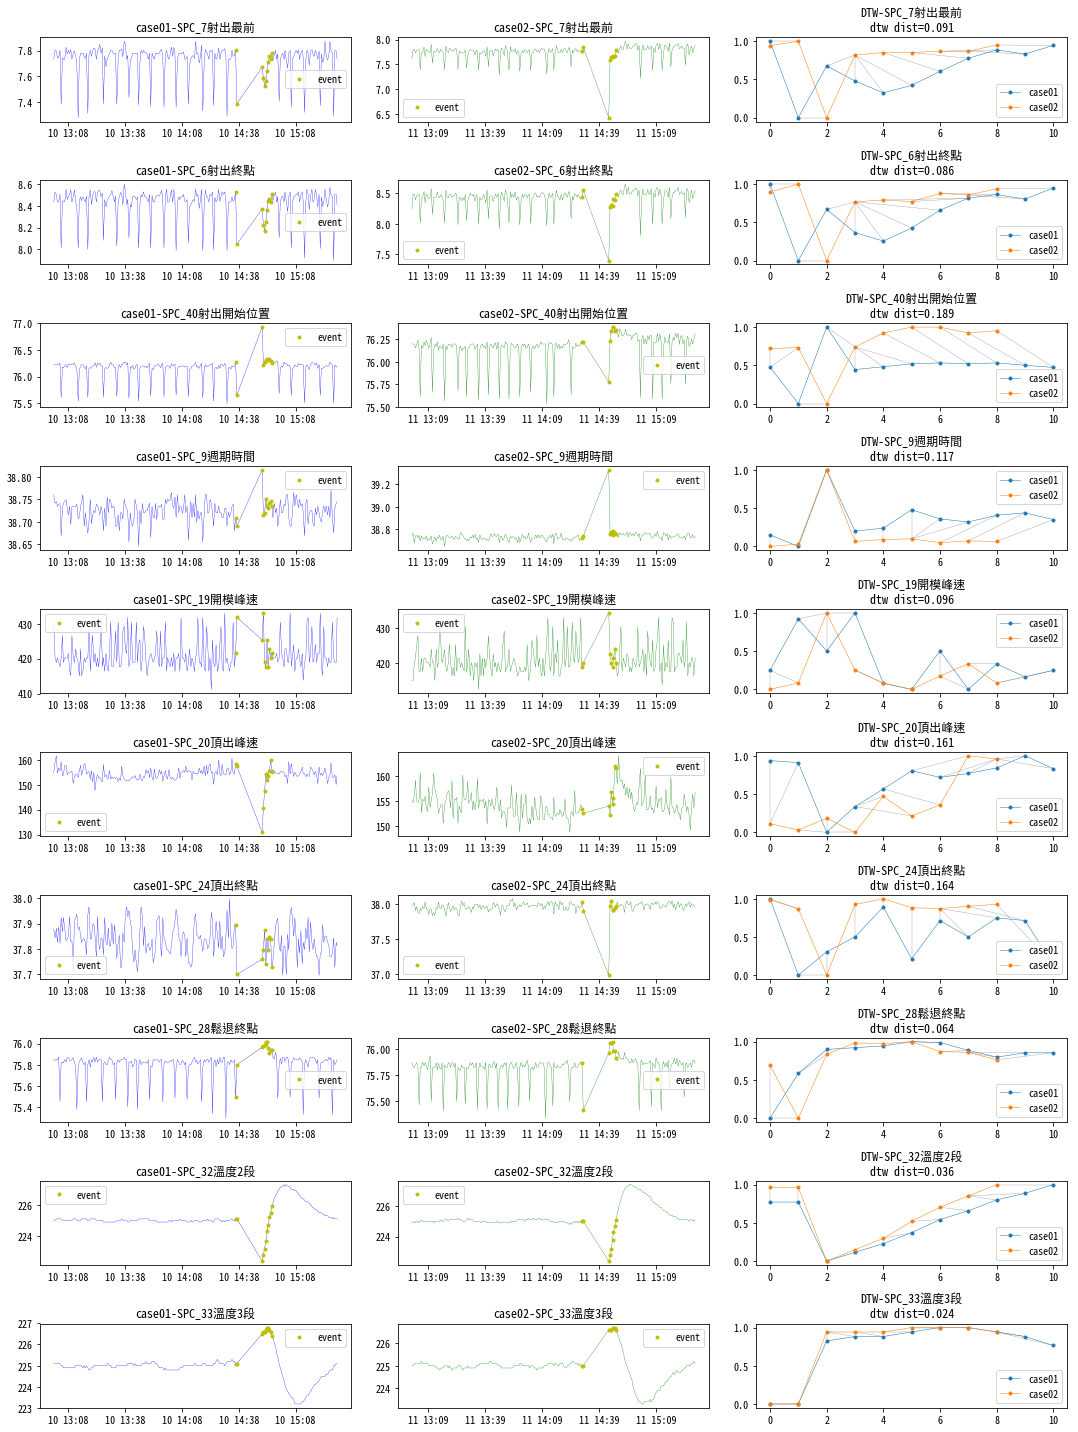

In [5]:
spccol_mapping = data.spccol_mapping
plt.figure(figsize=(20,20)) 
for i,f in enumerate(spc_feature):
    plt.subplot(10,4,4*i+1)
    plt.plot(df_ctr1['dt'], df_ctr1[f],'b-',linewidth=0.3, label='')
    plt.plot(df_evt1['dt'], df_evt1[f],'y.', label='event')
    plt.legend()
    plt.title('case01-'+f+spccol_mapping[f])

for i,f in enumerate(spc_feature):
    plt.subplot(10,4,4*i+2)
    plt.plot(df_ctr2['dt'], df_ctr2[f],'g-',linewidth=0.3, label='')
    plt.plot(df_evt2['dt'], df_evt2[f],'y.', label='event')
    plt.legend()
    plt.title('case02-'+f+spccol_mapping[f])

dist_sum=0
for i,f in enumerate(spc_feature):
    plt.subplot(10,4,4*i+3)
    #d, cost_matrix, acc_cost_matrix, path = dtw(df_sca1[:,i],df_sca2[:,i],dist=euclidean_norm)
    d,path = dict_dtwSummary[f]['d'], dict_dtwSummary[f]['path']
    dist_sum+=d
    msg = f"dtw dist={np.round(d,3)}"
    plt.plot(df_sca1[:,i],'.-',linewidth=0.5,label='case01')
    plt.plot(df_sca2[:,i],'.-',linewidth=0.5,label='case02')
    plt.legend()
    matches=list(zip(path[0],(path[1])))
    for m, n in matches:
        plt.plot((m, n), (df_sca1[:,i][m], df_sca2[:,i][n]), color = 'gray',lw=0.3)
    plt.title('DTW-'+f+spccol_mapping[f]+'\n'+msg)

plt.tight_layout()        
plt.show()